In [1]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec

In [2]:
# Load the cleaned data
df = pd.read_csv('cleaned_flights.csv')

# Display basic information about the dataset
print("Dataframe dimensions:", df.shape)
print("Columns and data types:")
print(df.dtypes)

Dataframe dimensions: (457013, 11)
Columns and data types:
AIRLINE                 object
ORIGIN_AIRPORT          object
DESTINATION_AIRPORT     object
SCHEDULED_DEPARTURE     object
DEPARTURE_TIME          object
DEPARTURE_DELAY        float64
SCHEDULED_ARRIVAL       object
ARRIVAL_TIME            object
ARRIVAL_DELAY          float64
SCHEDULED_TIME         float64
ELAPSED_TIME           float64
dtype: object


In [3]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
#_______________________________________________________________
# Creation of a dataframe with statitical infos on each airline:
global_stats = df['DEPARTURE_DELAY'].groupby(df['AIRLINE']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,min,max,count,mean
AIRLINE,,,,
VX,-20.0,397.0,4647.0,6.896277
HA,-26.0,1003.0,6408.0,1.311954
F9,-32.0,696.0,6735.0,17.910765
NK,-28.0,557.0,8632.0,13.073100
AS,-47.0,444.0,13151.0,3.072086
B6,-27.0,500.0,20482.0,9.988331
MQ,-29.0,780.0,27568.0,15.995865
US,-26.0,638.0,32478.0,5.175011
UA,-40.0,886.0,37363.0,13.885555


In [4]:
import json

# Load abbr_companies from the JSON file
with open('abbr_companies.json', 'r') as f:
    abbr_companies = json.load(f)

print("abbr_companies has been loaded successfully")

abbr_companies has been loaded successfully


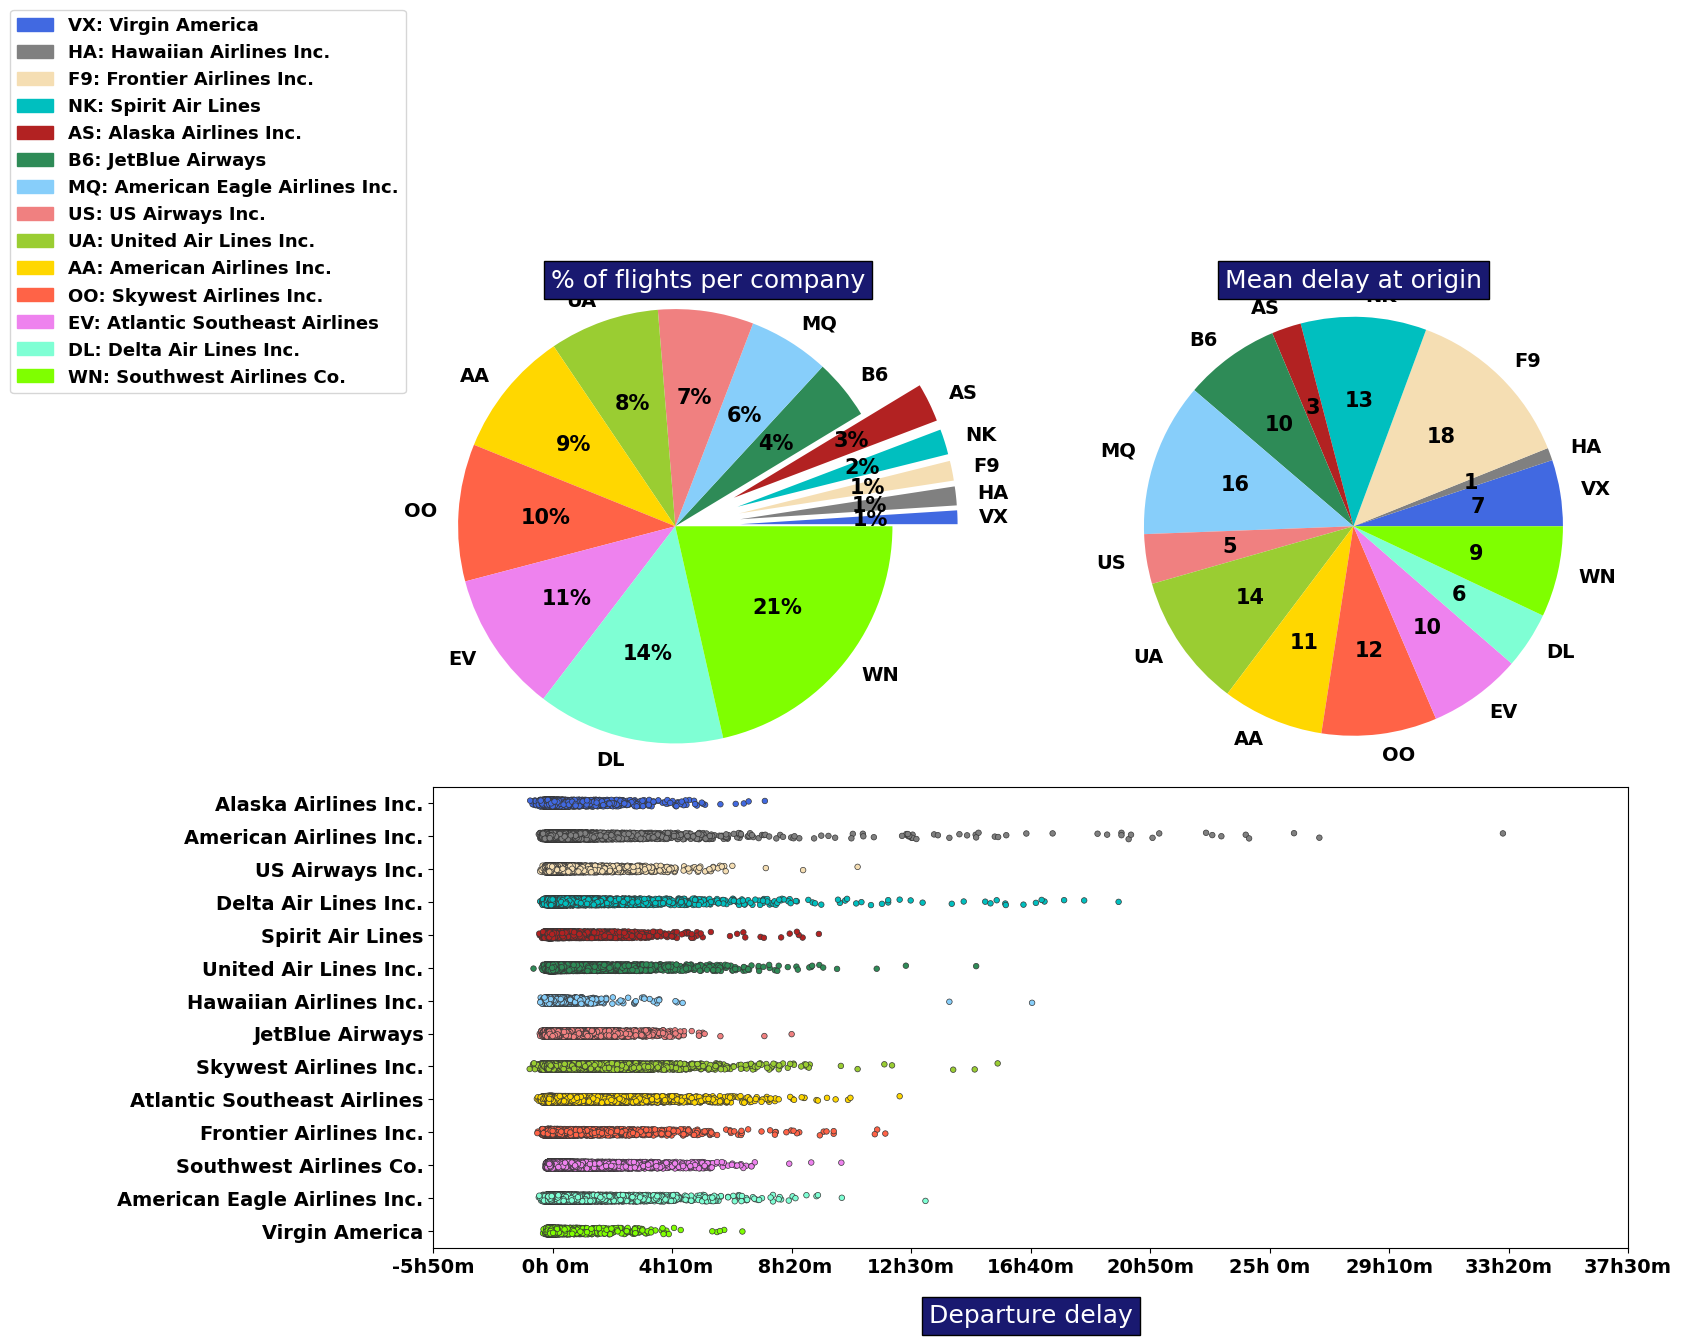

In [5]:
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings

font = {'family': 'sans-serif', 'weight': 'bold', 'size': 15}
mpl.rc('font', **font)
import matplotlib.patches as mpatches

# Extract a subset of columns and redefine the airlines labeling
df2 = df.loc[:, ['AIRLINE', 'DEPARTURE_DELAY']]
df2['AIRLINE'] = df2['AIRLINE'].replace(abbr_companies)

# Define colors for the plots
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse']

# Create the figure and subplots
fig = plt.figure(1, figsize=(16, 15))
gs = GridSpec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

# ------------------------------
# Pie chart 1: Number of flights
# ------------------------------
labels = [s for s in global_stats.index]
sizes = global_stats['count'].values
explode = [0.3 if sizes[i] < 20000 else 0.0 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax1.pie(sizes, explode=explode,
                                    labels=labels, colors=colors, autopct='%1.0f%%',
                                    shadow=False, startangle=0)
for text in texts:
    text.set_fontsize(14)
ax1.axis('equal')
ax1.set_title('% of flights per company', bbox={'facecolor': 'midnightblue', 'pad': 5},
              color='w', fontsize=18)

# Add legend for pie chart 1
comp_handler = []
for i in range(len(abbr_companies)):
    comp_handler.append(mpatches.Patch(color=colors[i],
                                       label=global_stats.index[i] + ': ' + abbr_companies[global_stats.index[i]]))
ax1.legend(handles=comp_handler, bbox_to_anchor=(0.2, 0.9),
           fontsize=13, bbox_transform=plt.gcf().transFigure)

# ------------------------------
# Pie chart 2: Mean delay at departure
# ------------------------------
sizes = global_stats['mean'].values
sizes = [max(s, 0) for s in sizes]
explode = [0.0 if sizes[i] < 20000 else 0.01 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax2.pie(sizes, explode=explode, labels=labels,
                                    colors=colors, shadow=False, startangle=0,
                                    autopct=lambda p: '{:.0f}'.format(p * sum(sizes) / 100))
for text in texts:
    text.set_fontsize(14)
ax2.axis('equal')
ax2.set_title('Mean delay at origin', bbox={'facecolor': 'midnightblue', 'pad': 5},
              color='w', fontsize=18)

# ------------------------------
# Strip plot: Departure delays by airline
# ------------------------------
sns.stripplot(y="AIRLINE", x="DEPARTURE_DELAY", size=4, palette=colors,
              data=df2, linewidth=0.5, jitter=True, ax=ax3)

# Set x-tick labels with formatted time
xticks = ax3.get_xticks()
ax3.set_xticks(xticks)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*divmod(int(x), 60)) for x in xticks], fontsize=14)

# Set y-tick labels
ax3.set_yticklabels(ax3.get_yticklabels(), fontsize=14)

# Set x-axis label
ax3.set_xlabel('Departure delay', fontsize=18, bbox={'facecolor': 'midnightblue', 'pad': 5},
               color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)

# Adjust layout
plt.tight_layout(w_pad=3)
plt.show()

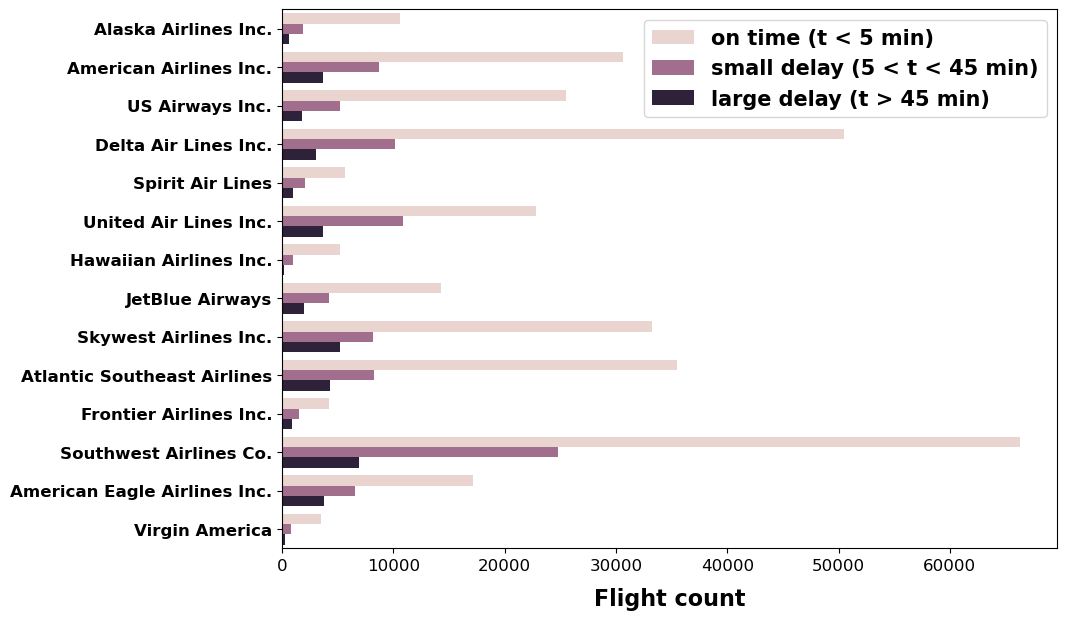

In [6]:
#_____________________________________________
# Function that define how delays are grouped
delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
df['DELAY_LEVEL'] = df['DEPARTURE_DELAY'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="AIRLINE", hue='DELAY_LEVEL', data=df)
#____________________________________________________________________________________
# We replace the abbreviations by the full names of the companies and set the labels
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)
#________________
# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.show()

Dataframe shape: (5714008, 26)
YEAR                     int64
MONTH                    int64
DATE                    object
DAY_OF_WEEK              int64
FLIGHT_NUMBER            int64
TAIL_NUMBER             object
AIRLINE                 object
ORIGIN_AIRPORT          object
DESTINATION_AIRPORT     object
DISTANCE                 int64
SCHED_DEP_HOUR           int64
SCHED_DEP_MIN            int64
DEP_HOUR               float64
DEP_MIN                float64
DEPARTURE_DELAY        float64
SCHED_ARR_HOUR           int64
SCHED_ARR_MIN            int64
ARR_HOUR               float64
ARR_MIN                float64
ARRIVAL_DELAY          float64
WHEELS_OFF_HOUR        float64
WHEELS_OFF_MIN         float64
WHEELS_ON_HOUR         float64
WHEELS_ON_MIN          float64
SCHEDULED_TIME         float64
CANCELLATION_REASON    float64
dtype: object
abbr_companies loaded.


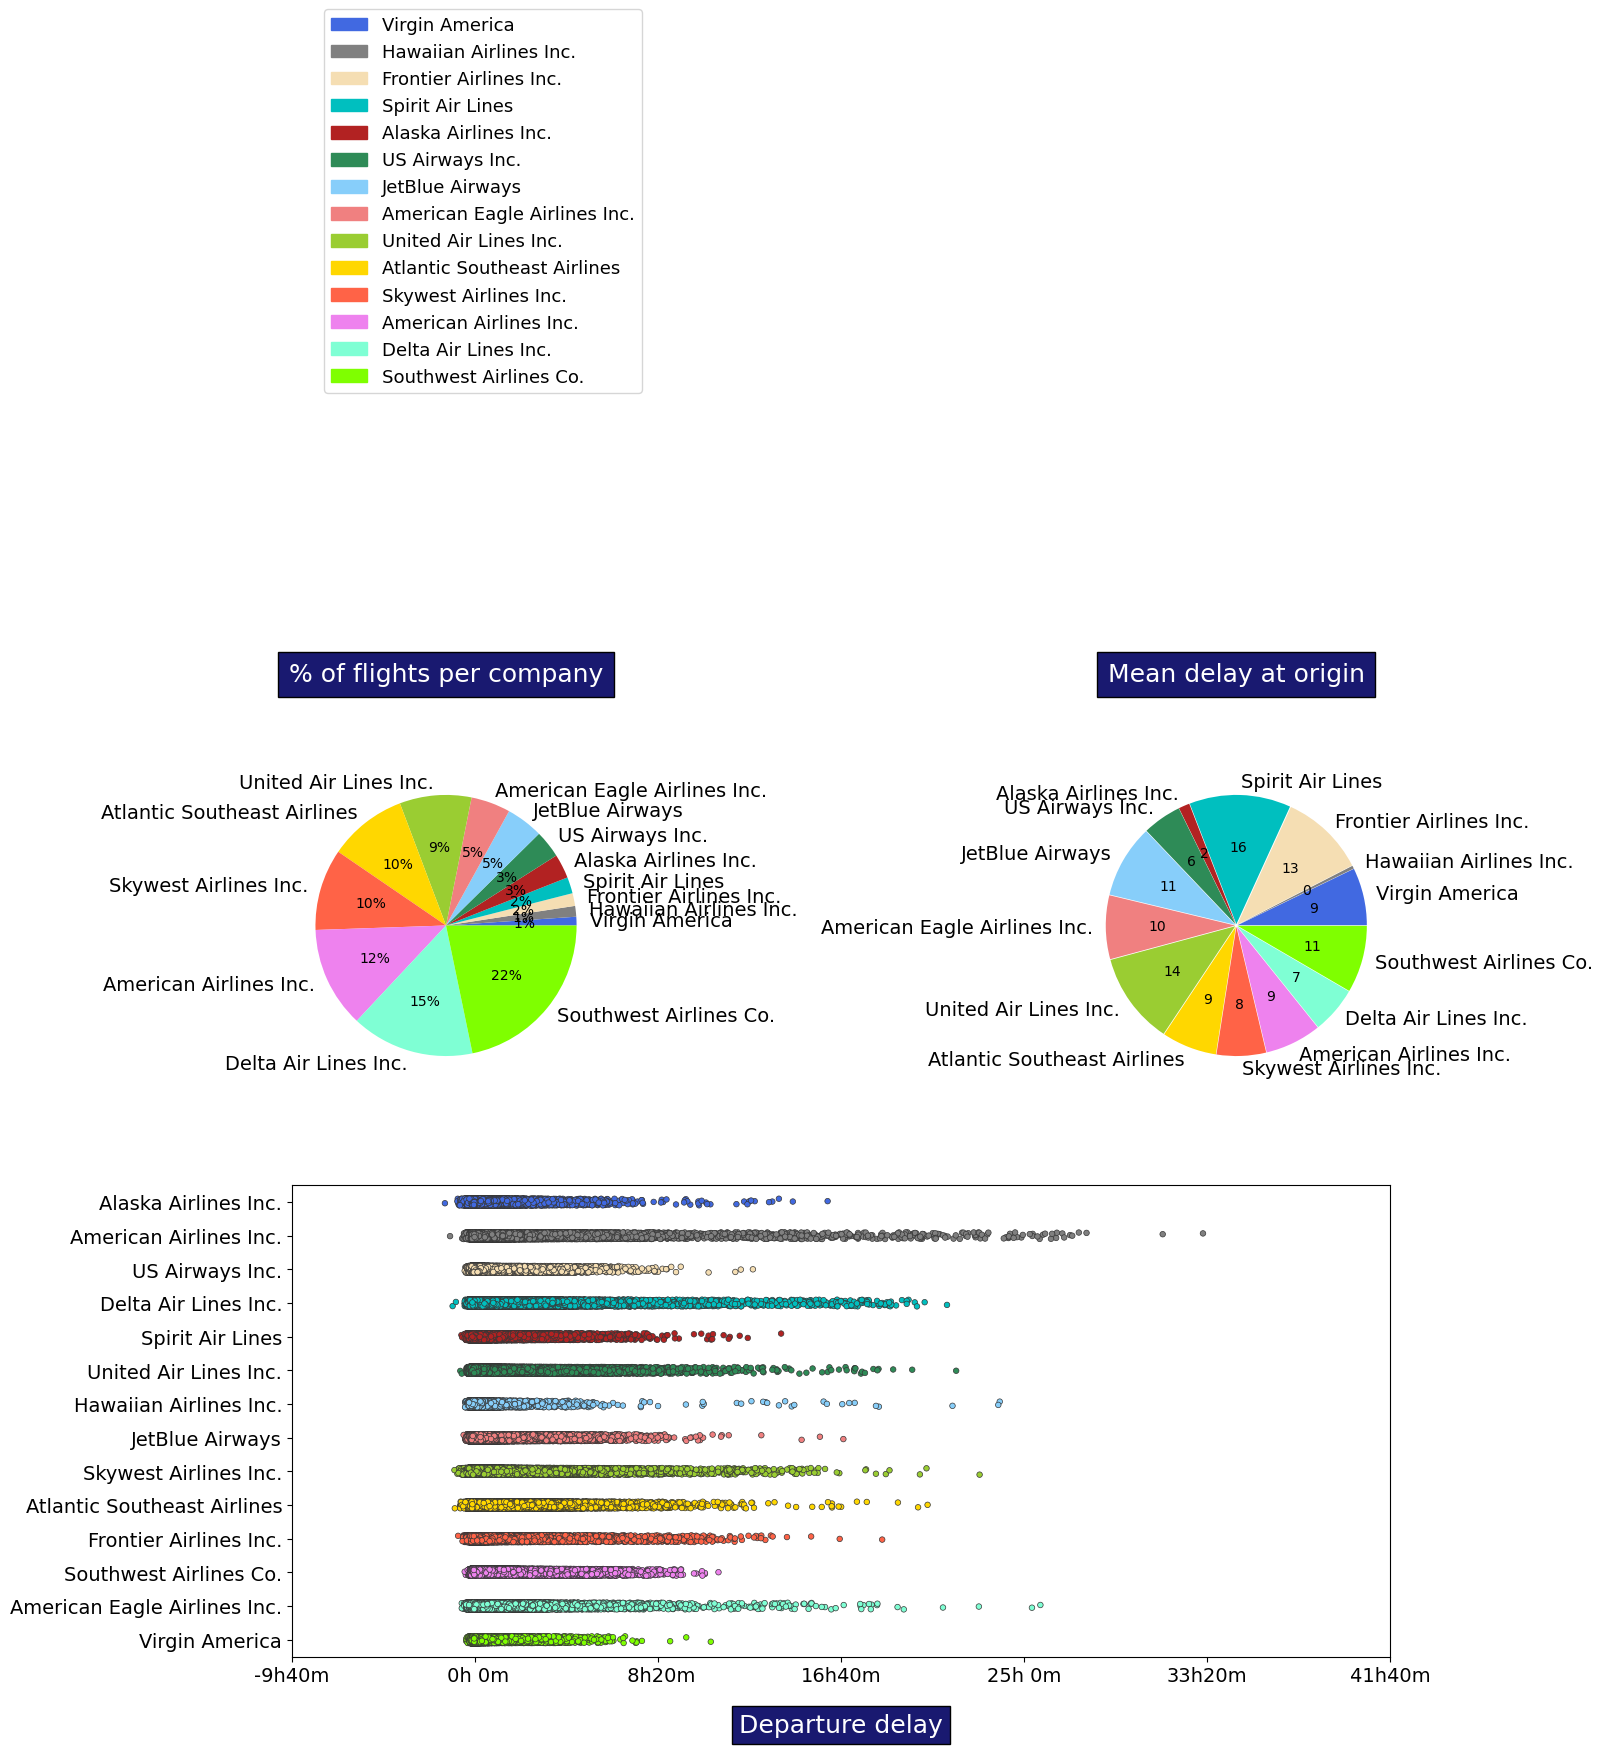

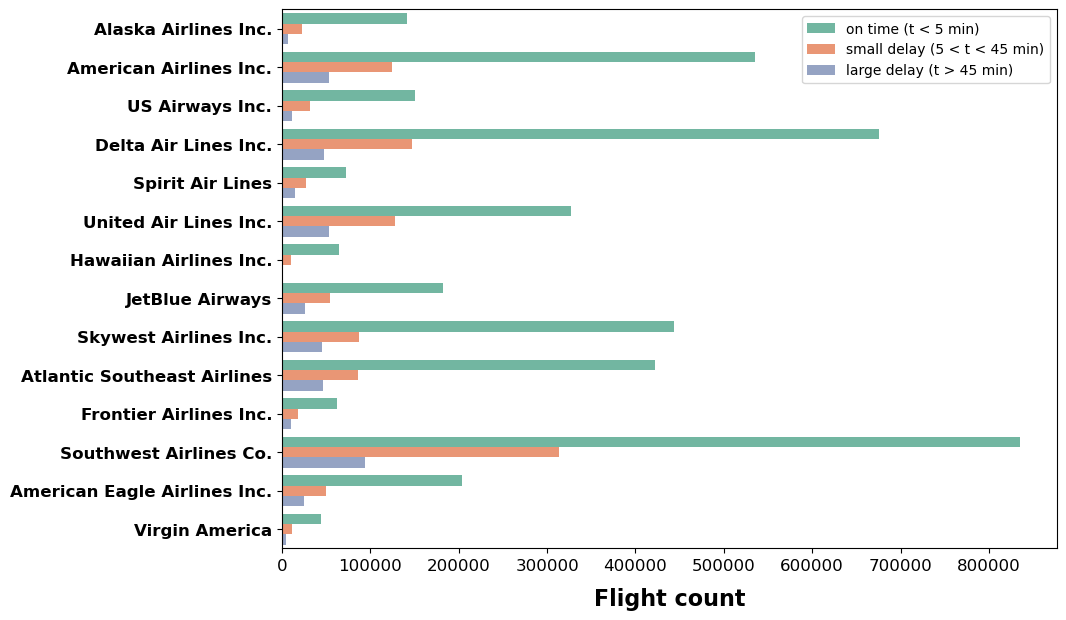

In [1]:
# EDA for cleaned_flights.csv

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import json
import matplotlib.patches as mpatches

# Load cleaned data
df = pd.read_csv('cleaned_flights.csv')

# Show basic info
print("Dataframe shape:", df.shape)
print(df.dtypes)

# Load airline code-to-name mapping
with open('abbr_companies.json', 'r') as f:
    abbr_companies = json.load(f)
print("abbr_companies loaded.")

# Replace airline codes with names for plots
df['AIRLINE_NAME'] = df['AIRLINE'].replace(abbr_companies)

# --- Airline delay stats ---
def get_stats(group):
    return {
        'min': group.min(),
        'max': group.max(),
        'count': group.count(),
        'mean': group.mean()
    }

global_stats = df.groupby('AIRLINE_NAME')['DEPARTURE_DELAY'].apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')

# --- Colors for plots ---
colors = [
    'royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
    'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse'
]

# --- Pie charts and strip plot ---
fig = plt.figure(figsize=(16, 15))
gs = GridSpec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

# Pie 1: Number of flights
labels = global_stats.index
sizes = global_stats['count'].values
explode = [0.3 if s < 20000 else 0.0 for s in sizes]
patches1, texts1, autotexts1 = ax1.pie(
    sizes, explode=explode, labels=labels, colors=colors, autopct='%1.0f%%',
    shadow=False, startangle=0
)
for t in texts1:
    t.set_fontsize(14)
ax1.axis('equal')
ax1.set_title('% of flights per company', bbox={'facecolor': 'midnightblue', 'pad': 5}, color='w', fontsize=18)
comp_handler = [
    mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))
]
ax1.legend(handles=comp_handler, bbox_to_anchor=(0.2, 0.9), fontsize=13, bbox_transform=plt.gcf().transFigure)

# Pie 2: Mean delay
mean_sizes = global_stats['mean'].fillna(0).values
explode2 = [0.0 if s < 20000 else 0.01 for s in sizes]
patches2, texts2, autotexts2 = ax2.pie(
    mean_sizes, explode=explode2, labels=labels, colors=colors, shadow=False, startangle=0,
    autopct=lambda p: '{:.0f}'.format(p * sum(mean_sizes) / 100)
)
for t in texts2:
    t.set_fontsize(14)
ax2.axis('equal')
ax2.set_title('Mean delay at origin', bbox={'facecolor': 'midnightblue', 'pad': 5}, color='w', fontsize=18)

# Strip plot: Departure delays by airline
sns.stripplot(
    y="AIRLINE_NAME", x="DEPARTURE_DELAY", size=4, palette=colors,
    data=df, linewidth=0.5, jitter=True, ax=ax3
)
xticks = ax3.get_xticks()
ax3.set_xticks(xticks)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*divmod(int(x), 60)) for x in xticks], fontsize=14)
ax3.set_yticklabels(ax3.get_yticklabels(), fontsize=14)
ax3.set_xlabel('Departure delay', fontsize=18, bbox={'facecolor': 'midnightblue', 'pad': 5}, color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)
plt.tight_layout(w_pad=3)
plt.show()

# --- Delay level barplot ---
def delay_type(x):
    if x > 45:
        return 2
    elif x > 5:
        return 1
    else:
        return 0

df['DELAY_LEVEL'] = df['DEPARTURE_DELAY'].apply(delay_type)
fig2 = plt.figure(figsize=(10, 7))
ax = sns.countplot(y="AIRLINE_NAME", hue='DELAY_LEVEL', data=df, palette='Set2')
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12, weight='bold')
plt.setp(ax.get_xticklabels(), fontsize=12, weight='normal', rotation=0)
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight='bold', labelpad=10)
L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.show()

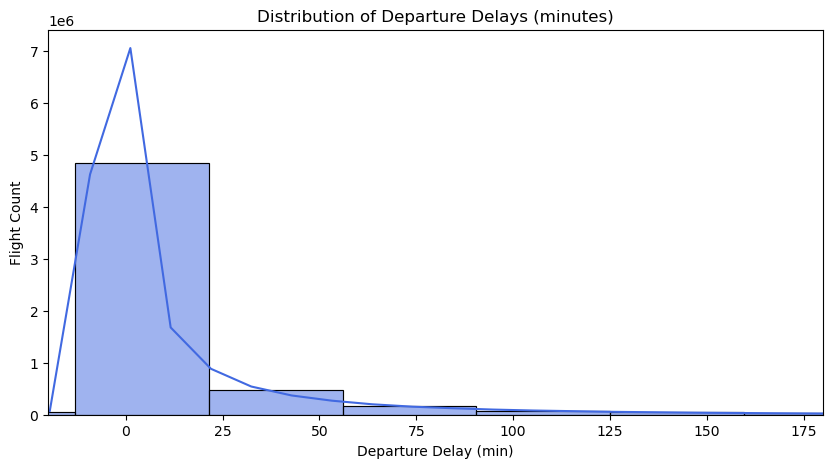

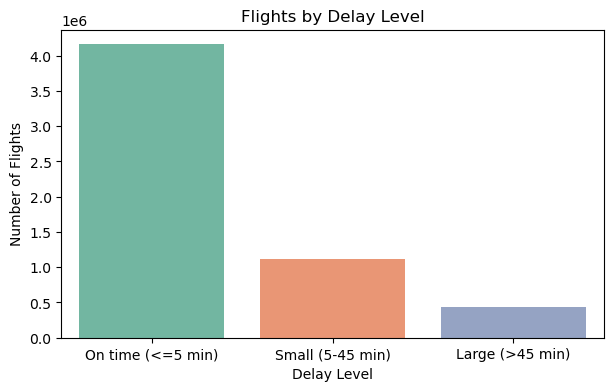

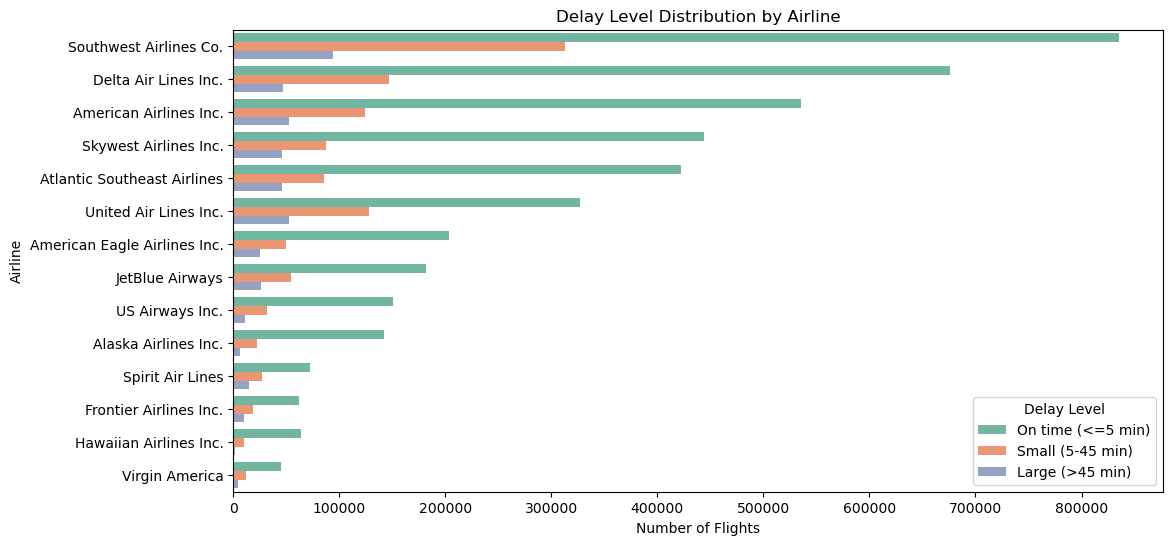

                                   mean  median    count
AIRLINE_NAME                                            
Hawaiian Airlines Inc.         0.469918    -4.0    76041
Alaska Airlines Inc.           1.718926    -4.0   171439
US Airways Inc.                6.081000    -2.0   194223
Delta Air Lines Inc.           7.313300    -1.0   870275
Skywest Airlines Inc.          7.736083    -3.0   576814
Atlantic Southeast Airlines    8.615598    -3.0   554752
American Airlines Inc.         8.826106    -2.0   712935
Virgin America                 8.993486    -1.0    61248
American Eagle Airlines Inc.   9.967187    -2.0   278791
Southwest Airlines Co.        10.517183     0.0  1242403
JetBlue Airways               11.442467    -2.0   262042
Frontier Airlines Inc.        13.303352    -2.0    90090
United Air Lines Inc.         14.333056     1.0   507762
Spirit Air Lines              15.883101    -1.0   115193


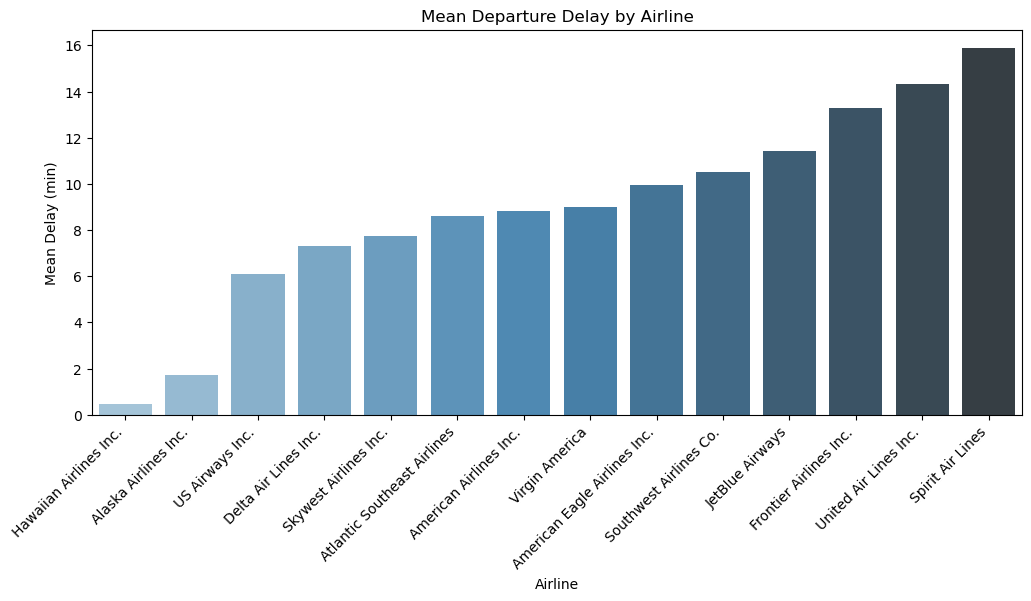

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
warnings.filterwarnings("ignore")

# Load data
df = pd.read_csv('cleaned_flights.csv')
with open('abbr_companies.json', 'r') as f:
    abbr_companies = json.load(f)
df['AIRLINE_NAME'] = df['AIRLINE'].replace(abbr_companies)

# Delay categories
def delay_level(x):
    if x > 45:
        return 'Large (>45 min)'
    elif x > 5:
        return 'Small (5-45 min)'
    else:
        return 'On time (<=5 min)'
df['DELAY_LEVEL'] = df['DEPARTURE_DELAY'].apply(delay_level)

# 1. Overall delay distribution
plt.figure(figsize=(10,5))
sns.histplot(df['DEPARTURE_DELAY'], bins=60, kde=True, color='royalblue')
plt.title('Distribution of Departure Delays (minutes)')
plt.xlabel('Departure Delay (min)')
plt.ylabel('Flight Count')
plt.xlim(-20, 180)
plt.show()

# 2. Delay level counts (all airlines)
plt.figure(figsize=(7,4))
sns.countplot(x='DELAY_LEVEL', data=df, order=['On time (<=5 min)','Small (5-45 min)','Large (>45 min)'], palette='Set2')
plt.title('Flights by Delay Level')
plt.xlabel('Delay Level')
plt.ylabel('Number of Flights')
plt.show()

# 3. Delay level by airline
plt.figure(figsize=(12,6))
sns.countplot(y='AIRLINE_NAME', hue='DELAY_LEVEL', data=df, order=df['AIRLINE_NAME'].value_counts().index, palette='Set2')
plt.title('Delay Level Distribution by Airline')
plt.xlabel('Number of Flights')
plt.ylabel('Airline')
plt.legend(title='Delay Level')
plt.show()

# 4. Airline mean/median delay
delay_stats = df.groupby('AIRLINE_NAME')['DEPARTURE_DELAY'].agg(['mean','median','count']).sort_values('mean')
print(delay_stats)

plt.figure(figsize=(12,5))
sns.barplot(x=delay_stats.index, y=delay_stats['mean'], palette='Blues_d')
plt.xticks(rotation=45, ha='right')
plt.title('Mean Departure Delay by Airline')
plt.ylabel('Mean Delay (min)')
plt.xlabel('Airline')
plt.show()